In [93]:
# (1) Import the required Python dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [94]:
# (2) Load the Bike Sharing dataset (data/bike-sharing-data/day.csv) into a Pandas DataFrame
bike_sharing_raw_df = pd.read_csv('/data/workspaces/jillur.quddus/jupyter/notebooks/Machine-Learning-with-Apache-Spark-QuickStart-Guide/chapter04/data/bike-sharing-data/day.csv', 
                                 delimiter = ',')
bike_sharing_raw_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


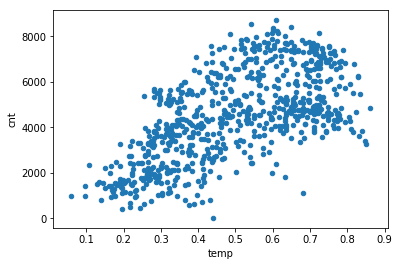

In [95]:
# (3.1) Raw Data Exploration - Plot normalized temperature (celsius) against count of total rental bikes
bike_sharing_raw_df.plot.scatter(x='temp', y='cnt')

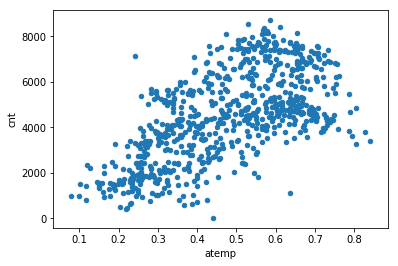

In [96]:
# (3.2) Raw Data Exploration - Plot normalized feeling temperature (celsius) against count of total rental bikes
bike_sharing_raw_df.plot.scatter(x='atemp', y='cnt')

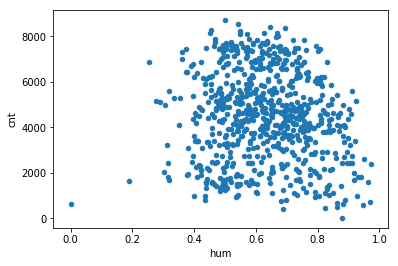

In [97]:
# (3.3) Raw Data Exploration - Plot normalized humidity against count of total rental bikes
bike_sharing_raw_df.plot.scatter(x='hum', y='cnt')

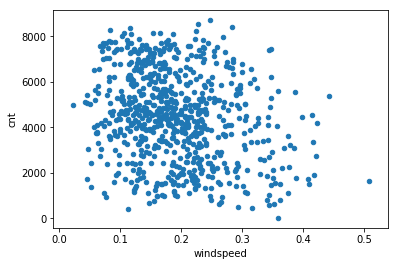

In [98]:
# (3.4) Raw Data Exploration - Plot normalized wind speed against count of total rental bikes
bike_sharing_raw_df.plot.scatter(x='windspeed', y='cnt')

In [99]:
# (4) Instantiate a Spark Context
conf = SparkConf().setMaster("spark://192.168.56.10:7077").setAppName("Univariate Linear Regression - Bike Sharing")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [100]:
# (5) Load the Bike Sharing dataset into a Spark DataFrame
bike_sharing_df = sqlContext.read.format('com.databricks.spark.csv').options(header = 'true', inferschema = 'true').load('/data/workspaces/jillur.quddus/jupyter/notebooks/Machine-Learning-with-Apache-Spark-QuickStart-Guide/chapter04/data/bike-sharing-data/day.csv')
bike_sharing_df.head(10)
bike_sharing_df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [101]:
# (6) Calculate standard statistical descriptive analytics on the raw Bike Sharing Spark DataFrame
bike_sharing_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
instant,731,366.0,211.16581162678773,1,731
season,731,2.496580027359781,1.1108070927726252,1,4
yr,731,0.5006839945280438,0.5003418803818265,0,1
mnth,731,6.519835841313269,3.451912787256252,1,12
holiday,731,0.028727770177838577,0.16715474262247393,0,1
weekday,731,2.997264021887825,2.004786917944481,0,6
workingday,731,0.6839945280437757,0.4652333866777039,0,1
weathersit,731,1.3953488372093024,0.5448943419593665,1,3
temp,731,0.49538478850889184,0.18305099611148876,0.0591304,0.861667


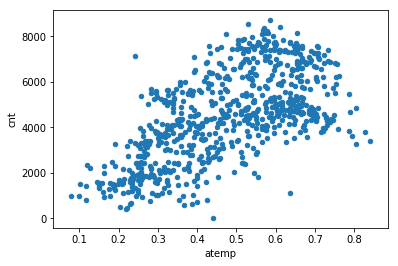

In [102]:
# (7) Explore a Spark DataFrame
bike_sharing_df.toPandas().plot.scatter(x='atemp', y='cnt')

In [103]:
# (8) Generate Input Feature Vectors from the Raw Spark DataFrame
univariate_feature_column = 'atemp'
univariate_label_column = 'cnt'
vector_assembler = VectorAssembler(inputCols = [univariate_feature_column], outputCol = 'features')
bike_sharing_features_df = vector_assembler.transform(bike_sharing_df).select(['features', univariate_label_column])
bike_sharing_features_df.head(10)

[Row(features=DenseVector([0.3636]), cnt=985),
 Row(features=DenseVector([0.3537]), cnt=801),
 Row(features=DenseVector([0.1894]), cnt=1349),
 Row(features=DenseVector([0.2121]), cnt=1562),
 Row(features=DenseVector([0.2293]), cnt=1600),
 Row(features=DenseVector([0.2332]), cnt=1606),
 Row(features=DenseVector([0.2088]), cnt=1510),
 Row(features=DenseVector([0.1623]), cnt=959),
 Row(features=DenseVector([0.1162]), cnt=822),
 Row(features=DenseVector([0.1509]), cnt=1321)]

In [104]:
# (9) Split the Raw DataFrame into a Training DataFrame and a Test DataFrame
train_df, test_df = bike_sharing_features_df.randomSplit([0.75, 0.25], seed=12345)
train_df.count(), test_df.count()

(534, 197)

In [105]:
# (10) Train a Linear Regression Model on the Training DataFrame
linear_regression = LinearRegression(featuresCol = 'features', labelCol = univariate_label_column)
linear_regression_model = linear_regression.fit(train_df)

In [108]:
# (11) Output Linear Regression Model Summary Statistics to evaluate the Training Model
print("Model Coefficients: " + str(linear_regression_model.coefficients))
print("Intercept: " + str(linear_regression_model.intercept))
training_summary = linear_regression_model.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)
print("R-SQUARED: %f" % training_summary.r2)
print("TRAINING DATASET DESCRIPTIVE SUMMARY: ")
train_df.describe().show()
print("TRAINING DATASET RESIDUALS: ")
training_summary.residuals.show()

Model Coefficients: [7733.74530697443]
Intercept: 829.620083898751
RMSE: 1490.119939
R-SQUARED: 0.415185
TRAINING DATASET DESCRIPTIVE SUMMARY: 
+-------+------------------+
|summary|               cnt|
+-------+------------------+
|  count|               534|
|   mean|  4460.51872659176|
| stddev|1950.3795971090806|
|    min|               441|
|    max|              8714|
+-------+------------------+

TRAINING DATASET RESIDUALS: 
+-------------------+
|          residuals|
+-------------------+
|-460.12423182309635|
| -608.0165096693272|
|  -86.8171643151577|
| -906.0879449365052|
|  615.4579524028416|
|  429.8012274630528|
|  -590.510777050974|
| -675.5494457775085|
|-507.26030693444636|
| -908.6773945448585|
|  231.4133308615069|
|-107.42025995535232|
| -655.2832316127488|
|  247.4316890832215|
| -818.3519245911252|
| -769.0301473227387|
| -865.7582384217244|
| -945.4301137662428|
|  992.6744254544424|
| -6.159165362416843|
+-------------------+
only showing top 20 rows



In [110]:
# (12) Apply the Trained Linear Regression Model to the Test DataFrame to make predictions
test_linear_regression_predictions_df = linear_regression_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_linear_regression_predictions_df.select("prediction", univariate_label_column, "features").show(10)

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+------------------+----+----------+
|        prediction| cnt|  features|
+------------------+----+----------+
|1741.6606679502454|1416| [0.11793]|
|1945.4680580249424|1605|[0.144283]|
|1986.1862270661627|1538|[0.149548]|
|  2084.45119493658| 959|[0.162254]|
|2182.0587944559043|1301|[0.174875]|
| 2196.721975557928|1000|[0.176771]|
|2528.7239278410334| 431|  [0.2197]|
|2582.4115877620497|2114|[0.226642]|
|2592.2411780472144|3422|[0.227913]|
| 2643.415370743464|1360| [0.23453]|
+------------------+----+----------+
only showing top 10 rows



In [115]:
# (13) Evaluate the performance of our Linear Regression Model on the Test DataFrame using a Regression Evaluator
linear_regression_evaluator_rmse = RegressionEvaluator(predictionCol = "prediction", labelCol = univariate_label_column, metricName = "rmse")
linear_regression_evaluator_r2 = RegressionEvaluator(predictionCol = "prediction", labelCol = univariate_label_column, metricName = "r2")
print("RMSE on Test Data = %g" % linear_regression_evaluator_rmse.evaluate(test_linear_regression_predictions_df))
print("R-SQUARED on Test Data = %g" % linear_regression_evaluator_r2.evaluate(test_linear_regression_predictions_df))

RMSE on Test Data = 1534.51
R-SQUARED on Test Data = 0.344996


In [118]:
# (14) Alternatively we can use the Test Summary Results
test_summary = linear_regression_model.evaluate(test_df)
print("RMSE on Test Data = %g" % test_summary.rootMeanSquaredError)
print("R-SQUARED on Test Data = %g" % test_summary.r2)

RMSE on Test Data = 1534.51
R-SQUARED on Test Data = 0.344996


In [119]:
# (15) Stop the Spark Context
sc.stop()